In [16]:
import numpy as np
import pandas as pd

from pyquaternion import Quaternion as quat
from scipy.spatial.transform import Rotation as R

%matplotlib inline
import matplotlib.pyplot as plt

'''
Orientation Conventions

Euler angles/(Roll-Pitch-Yaw):
    X-axis is positive forward, through the nose of the aircraft
    Y-axis is positive out the right wing
    Z-axis is positive down (so that right hand rule is obeyed)
    Rotation is clockwise, obeying right hand rule with thumb being positive direction
    Sequence of operations: ZYX or yaw-pitch-roll
'''

'\nOrientation Conventions\n\nEuler angles/(Roll-Pitch-Yaw):\n    X-axis is positive forward, through the nose of the aircraft\n    Y-axis is positive out the right wing\n    Z-axis is positive down (so that right hand rule is obeyed)\n    Rotation is clockwise, obeying right hand rule with thumb being positive direction\n    Sequence of operations: ZYX or yaw-pitch-roll\n'

In [17]:
data_path = "data/2019_06_18_16_22_24"

tcm_raw = pd.read_csv( data_path+"tcm.csv", header=0, names=["Time", "roll", "pitch", "yaw"])
vnav_raw = pd.read_csv( data_path+"vnav.csv", header=0, names=["Time", "yaw","pitch","roll","magx","magy","magz","accelx","accely","accelz","gyrox","gyroy","gyroz"])
yost_raw = pd.read_csv( data_path+"yost.csv", header=0, names=["Time", "quat 1", "quat 2", "quat 3","quat 4"])
all_raw = [tcm_raw, vnav_raw, yost_raw]

In [18]:
## Set time as index
for f in all_raw:
    f.set_index("Time", inplace=True)

## TODOS:

* Vectornav:
* Yost Labs:
* TCM:  Add magnetometer/compass data

* Convert to common reference frame (perhaps using quaternions)

In [19]:
## Quaternions to euler angles
def quat2euler( row ): 
    r = R.from_quat([ row["quat 1"], row["quat 2"], row["quat 3"], row["quat 4"] ])
    e = r.as_euler('zyx')
    return pd.Series( {'yaw': e[0], 'pitch': e[1], 'roll': e[2]})

# Accepts Euler Angles of various orders, default = 'zyx'
def euler2quat( row, order='zyx' ):
    r = R.from_euler( order, [row["roll"], row["pitch"], row["yaw"]])
    q = r.as_quat()
    return pd.Series( {'quat 1': q[0], 'quat 2': q[1], 'quat 3': q[2], 'quat 4': q[3]} )

In [20]:
# ## Convert to degrees?
# for col in ["roll", "pitch", "yaw"]:
#     tcm_raw[col] = tcm_raw[col] * 180/np.pi 

quat = tcm_raw.apply( euler2quat, axis=1 )

tcm = tcm_raw.merge( quat, left_index=True, right_index=True )
    
tcm.head(5)

,roll,pitch,yaw,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,
0.071,-0.019519,-0.057181,-4.940356,-0.622029,0.016312,0.025421,-0.782411
0.147,-0.019613,-0.057242,-4.941354,-0.621639,0.016319,0.025468,-0.782720
0.253,-0.019597,-0.057223,-4.942251,-0.621288,0.016328,0.025449,-0.782999
0.357,-0.019456,-0.057114,-4.942882,-0.621040,0.016337,0.025354,-0.783198
0.472,-0.019258,-0.056930,-4.942798,-0.621072,0.016326,0.025220,-0.783177


In [21]:
## Convert to radians?
for col in ["roll", "pitch", "yaw"]:
    vnav_raw[col] = vnav_raw[col] * np.pi/180

quat = vnav_raw.apply( euler2quat, axis=1 )

vnav = vnav_raw.merge( quat, left_index=True, right_index=True )

vnav.head(5)

,yaw,pitch,roll,magx,magy,magz,accelx,accely,accelz,gyrox,gyroy,gyroz,quat 1,quat 2,quat 3,quat 4
Time,,,,,,,,,,,,,,,,
0.075,-0.298120,-0.052063,-0.011589,0.0474,0.2314,0.4046,-0.542,0.085,-9.735,0.001854,-0.001146,0.000669,-0.148307,-0.026600,-0.001863,0.988582
0.152,-0.298067,-0.052063,-0.011641,0.0494,0.2278,0.4008,-0.541,0.156,-9.746,-0.000301,-0.002110,0.002550,-0.148280,-0.026604,-0.001889,0.988586
0.258,-0.298032,-0.052028,-0.011711,0.0452,0.2267,0.4058,-0.388,0.245,-9.804,-0.000662,-0.004455,0.001036,-0.148262,-0.026592,-0.001927,0.988589
0.361,-0.297928,-0.052063,-0.011676,0.0472,0.2230,0.4034,-0.489,0.242,-9.819,0.001404,-0.001896,-0.000512,-0.148210,-0.026606,-0.001909,0.988596
0.475,-0.297963,-0.052063,-0.011676,0.0452,0.2243,0.4046,-0.495,0.124,-9.748,0.000877,-0.000018,0.001819,-0.148228,-0.026606,-0.001908,0.988593


In [33]:
#---------OBJECTIVE: POST PROCESSING-------------
# NEED TO INVERT WITH QUAT MULT (FLIP UPSIDE DOWN, PITCH BY 180, OR MULT BY quaternion 'rot' => (0,0,1,0))
# INVERT BEFORE CONVERTING TO EULER.
# CREATE quat() obj of each row 'q', then replace q with rot * q / rot. (This part im a little fuzzy still)
#---------POST PROCESSING-------------

# Flip quaternions
def flip(row):
    vals = row.to_numpy()
    q = quat(vals)
    rot = quat(0,0,1,0)
    flipped = (rot * q / rot).elements # This is p * q * p^-1 based on my understanding of quaternion operations
    return pd.Series( {'quat 1': flipped[0], 'quat 2': flipped[1], 'quat 3': flipped[2], 'quat 4': flipped[3]} )

yost_flipped = yost_raw.apply(flip, axis=1)
print(yost_flipped.head())
euler = yost_flipped.apply( quat2euler, axis=1 )
yost = yost_flipped.merge( euler, left_index=True, right_index=True )
yost.head(5)

         quat 1    quat 2    quat 3    quat 4
Time                                         
0.176 -0.065458  0.007237 -0.997616  0.020623
0.283 -0.065476  0.007262 -0.997614  0.020664
0.402 -0.065441  0.007227 -0.997616  0.020696
0.498 -0.065420  0.007310 -0.997617  0.020642
0.598 -0.065400  0.007348 -0.997616  0.020742


TypeError: ("'DataFrame' object is not callable", 'occurred at index 0.17599987983703613')

<Figure size 432x288 with 0 Axes>

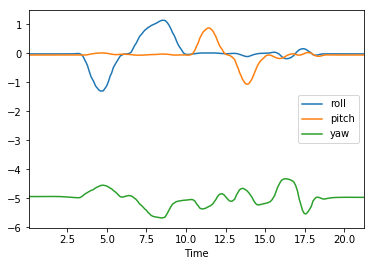

In [10]:
plt.figure()
tcm_raw.plot()

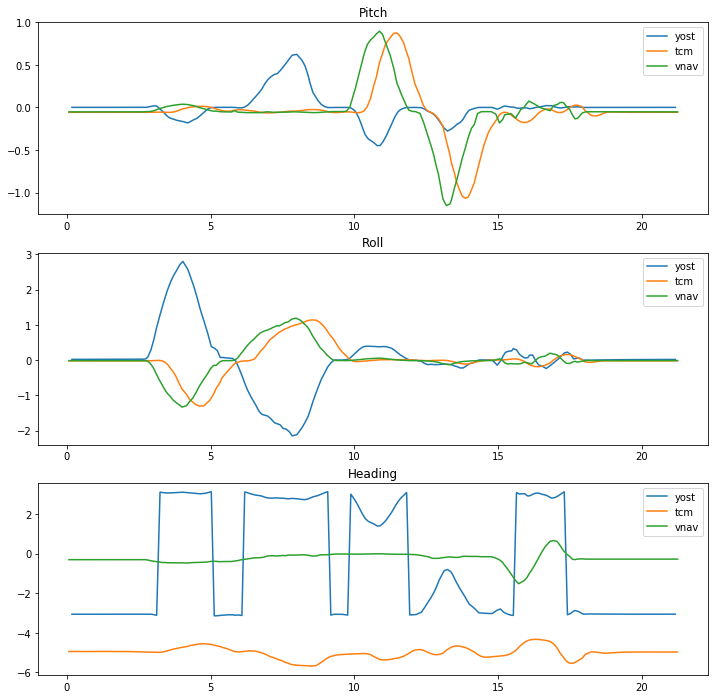

In [11]:
fig,ax = plt.subplots(3,1, figsize=(12,12))

ax[0].plot(yost['pitch'], label='yost')
ax[0].plot(tcm['pitch'], label='tcm')
ax[0].plot(vnav['pitch'], label='vnav')
ax[0].set_title('Pitch')
ax[0].legend()

ax[1].plot(yost['roll'], label='yost')
ax[1].plot(tcm['roll'], label='tcm')
ax[1].plot(vnav['roll'], label='vnav')
ax[1].set_title('Roll')
ax[1].legend()

ax[2].plot(yost['yaw'], label='yost')
ax[2].plot(tcm['yaw'], label='tcm')
ax[2].plot(vnav['yaw'], label='vnav')
ax[2].set_title('Heading')
ax[2].legend()